## Prepare TCGA counts

In [ ]:
#download GDC ChGR37 data from XENA, TCGA Kidney Chromophobe (KICH)
#https://xenabrowser.net/datapages/?hub=https://tcga.xenahubs.net:443
'''
!wget https://tcga.xenahubs.net/download/unc_v2_exon_hg19_probe_TCGA
!wget https://tcga.xenahubs.net/download/TCGA.KICH.sampleMap/HiSeqV2_exon.gz
!wget https://tcga.xenahubs.net/download/TCGA.KICH.sampleMap/miRNA_HiSeq_gene.gz
!gunzip HiSeqV2_exon.gz
!gunzip miRNA_HiSeq_gene.gz
!mv HiSeqV2_exon data/KICH
!mv miRNA_HiSeq_gene data/KICH
!mv unc_v2_exon_hg19_probe_TCGA data/KICH'''

In [1]:
import os
import pandas as pd
from pathlib import Path
path = Path('data')
tcga_path = Path(path/'KICH')
path_tarp = Path('../data')
path_input = Path('../data/all_cdna_subsets')

### Translate exon positions to GRCH38 using liftover

In [2]:
#read in exon counts
f = Path(path/'exon_counts_kidney.feather')
if f.is_file():
    print('read from file')
    exon_counts = pd.read_feather(f)
else:
    print('translate exon count positions from GRCh37 to GRCh38')
    counts_37 = pd.read_csv(tcga_path/'HiSeqV2_exon', delimiter='	')
    exon_counts = counts_37.copy()
    #split sample in seperate columns chromosome, start, end, strand
    new = exon_counts['sample'].str.split(':', 2, expand=True) 
    exon_counts['chrom_old'] = new[0].str[3:].astype('category')
    new2 = new[1].str.split('-', 1, expand=True)
    exon_counts['start_old'] = new2[0].astype(int)
    exon_counts['end_old'] = new2[1].astype(int)
    exon_counts['strand_old'] = exon_counts.apply(lambda row : '-1' if (row['sample'].split(':')[2] == '-') else '1', axis=1).astype('category')
    #save positions to BED input file
    exon_counts['score'] = 0
    exon_counts.to_csv('data/exon_hg19_pos.bed', sep='\t', columns=['chrom_old','start_old','end_old','sample','score','strand_old'], header=False, index=False)
    #translate positions from GRCh37 to GRCh38
    !../liftOver data/exon_hg19_pos.bed data/hg19ToHg38.over.chain.gz data/exon_hg38_pos.bed data/unlifted.bed
    #read in translated positions from liftOver output BED file
    translated_positions = pd.read_csv('data/exon_hg38_pos.bed', delimiter='	', names=['chromosome_name','chrom_exon_start','chrom_exon_end','id','score','strand'])
    exon_counts = exon_counts.merge(translated_positions[['chromosome_name','chrom_exon_start','chrom_exon_end','id','strand']], left_on='sample', right_on='id', how='inner',validate='1:1')
    exon_counts.drop(['sample','chrom_old','strand_old','start_old','end_old','score'], axis=1, inplace=True)
    #transform strand {-,+} to {-1,+1}
    exon_counts['strand'] = exon_counts.apply(lambda row: '-1' if row.strand == '-' else '1', axis=1).astype('category')
    exon_counts['chromosome_name'] = exon_counts['chromosome_name'].str[3:].astype('category')
    exon_counts[['chrom_exon_start','chrom_exon_end']] = exon_counts[['chrom_exon_start','chrom_exon_end']].astype('Int64')
    print(f'{len(exon_counts)}/{len(counts_37)} exon positions are kept.\n{(1-(len(exon_counts)/len(counts_37)))*100:.2f}% were lost during liftOver.')
    #exon_counts.to_feather(f)  

read from file


In [85]:
exon_counts

,TCGA-KN-8419-01,TCGA-KL-8346-01,TCGA-KN-8422-01,TCGA-KN-8431-11,TCGA-KN-8430-11,TCGA-KM-8440-01,TCGA-KO-8414-01,TCGA-KL-8323-01,TCGA-KM-8639-01,TCGA-KO-8415-11,...,TCGA-KO-8408-01,TCGA-KM-8443-01,TCGA-KM-8442-01,TCGA-KL-8332-11,TCGA-KL-8327-01,chromosome_name,chrom_exon_start,chrom_exon_end,id,strand
0,2.1156,1.7396,2.0641,3.1457,3.0436,2.2209,1.8213,1.9092,2.9139,3.1049,...,2.2369,2.4951,2.1010,3.0617,0.7424,3,51973965,51974630,chr3:52007981-52008646:-,-1
1,0.0000,0.0000,0.0000,0.0251,0.0233,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1,215728030,215728384,chr1:215901372-215901726:-,-1
2,0.3884,0.2219,0.2050,0.9168,0.6069,0.4547,0.1571,0.3857,0.7535,0.8673,...,0.1602,0.3507,0.7154,0.4353,0.0966,17,51191601,51193016,chr17:49268962-49270377:-,-1
3,2.5290,0.7196,1.3094,2.3074,1.6894,1.5829,1.0835,1.9041,1.2131,1.7214,...,0.6381,1.5227,1.7786,1.4157,0.0000,4,146292929,146292980,chr4:147214081-147214132:-,-1
4,0.0000,0.0000,0.0000,1.4721,0.1284,0.0000,0.0000,0.0000,0.0374,2.4087,...,0.0000,0.0189,0.1334,4.8648,0.0900,1,15747546,15747980,chr1:16074041-16074475:+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238791,2.4455,5.1078,2.9468,5.4212,5.1299,4.5371,3.5954,4.4245,4.4484,5.5820,...,5.0518,4.9067,3.8206,7.3459,4.1126,3,51978259,51978374,chr3:52012275-52012390:+,1
238792,1.5701,0.5500,0.3451,2.2783,1.7366,0.6813,0.5851,1.4460,2.4188,1.8648,...,0.8498,1.0774,0.8774,1.2410,0.2725,6,43357126,43357765,chr6:43324864-43325503:-,-1
238793,0.4810,0.4219,0.3687,0.7313,0.7666,0.7646,2.4586,0.9557,1.1452,1.9724,...,1.3415,1.8842,0.8646,0.0000,1.9102,17,36168630,36168695,chr17:34495988-34496053:-,-1
238794,2.6944,2.2891,1.8186,4.0291,4.0015,3.7968,2.3984,2.6564,4.2824,3.6833,...,3.0631,1.8938,2.9015,2.3518,1.1468,1,120833602,120833774,chr1:148010884-148011056:-,1


### Merge to add exon ID

In [3]:
#read in Ensembl exon info
# returns format {transcript_id : {exon_id : data}}
def read_in_fasta(file):
	file = open(file,'r').readlines()
	dict_ = {}
	for id_, line in enumerate(file):
		if line[0] == '>': 	# data is in next line
			transcript_id = re.search('ENST[^_]*',line).group(0)
			exon_id = re.search('ENSE[^\n]*',line).group(0)
			data = file[id_+1][:-1]
			data = int(data) if data != 'NA' else None
			dict_[transcript_id] = dict_.get(transcript_id, {})
			dict_[transcript_id][exon_id] = data
	return dict_

#returns format {transcript_id : {exon_id : chromosome_start}}, {transcript_id : {exon_id : start}}, {transcript_id : {exon_id : end}}, pandas DataFrame [exon_id, transcript_id, chrom_exon_start, chrom_exon_end]
def calc_exon_data(path):
	feather_file = Path(path/'exon_info.feather')
	if feather_file.is_file():
		#load file from disk
		exon_info = pd.read_feather(feather_file)
	else:
		chrom_exon_starts = read_in_fasta(path/'all_exon_start.fasta')
		chrom_exon_ends = read_in_fasta(path/'all_exon_end.fasta')
		exon_info = {}
		for tid in chrom_exon_starts:
			sorted_ = {k: v for k, v in sorted(chrom_exon_starts[tid].items(), key=lambda item: item[1])}
			for eid in sorted_:
				chrom_exon_start = chrom_exon_starts[tid][eid]
				chrom_exon_end = chrom_exon_ends[tid][eid]
				exon_info[eid] = [tid, chrom_exon_start, chrom_exon_end]
				#write to disk
		exon_info = pd.DataFrame.from_dict(exon_info, orient='index', columns=['transcript_id','chrom_exon_start', 'chrom_exon_end']).reset_index()
		exon_info = exon_info.rename(columns={'index': "exon_id"})
		exon_info.to_feather(feather_file)
	return exon_info

df_gene = pd.read_csv(path/'gene_infos.csv', dtype={'ensembl_gene_id':str,'ensembl_gene_id_version':str,'ensembl_transcript_id':str, 'ensembl_transcript_id_version':str, 'chromosome_name':'category', 'strand':'int8', 'start_position':int, 'end_position':int})
del df_gene['Unnamed: 0']
df_gene[['strand']] = df_gene[['strand']].astype('str').astype('category')
df_exon = calc_exon_data(path) # exon starts and ends per transcript + exon id
df_exon = df_exon.merge(df_gene, left_on = 'transcript_id', right_on = 'ensembl_transcript_id', how='left')
df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']] = df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']].astype('Int64')
df_exon['chromosome_name'] = df_exon['chromosome_name'].apply((lambda x: (x[4:] if x.startswith('CHR') else x)))
df_exon[['strand']] = df_exon[['strand']].astype('str').astype('category')

In [86]:
#print duplicates in df_exon (cases where different exon id for same exon)
df_exon[['exon_id','transcript_id','ensembl_gene_id','chromosome_name','strand','chrom_exon_start','chrom_exon_end']][df_exon.chrom_exon_start.duplicated(keep=False)].sort_values(by=['chrom_exon_start','chrom_exon_end'])

,exon_id,transcript_id,ensembl_gene_id,chromosome_name,strand,chrom_exon_start,chrom_exon_end
5535,ENSE00003726071,ENST00000612640,ENSG00000271254,KI270711.1,-1,6101,6370
5540,ENSE00003721193,ENST00000612721,ENSG00000271254,KI270711.1,-1,6101,6370
5520,ENSE00003712054,ENST00000612640,ENSG00000271254,KI270711.1,-1,6991,7102
5541,ENSE00003714206,ENST00000612721,ENSG00000271254,KI270711.1,-1,6991,7102
5550,ENSE00003720825,ENST00000616361,ENSG00000271254,KI270711.1,-1,6991,7102
...,...,...,...,...,...,...,...
395619,ENSE00002142255,ENST00000534456,ENSG00000171163,1,-1,248859015,248859144
27970,ENSE00003603972,ENST00000462488,ENSG00000185220,1,1,248913816,248913879
27973,ENSE00003610993,ENST00000329291,ENSG00000185220,1,1,248913816,248913879
27976,ENSE00001956622,ENST00000462488,ENSG00000185220,1,1,248917279,248917401


In [4]:
#get all direct matches with GRCh38
exon_counts2 = exon_counts[['chromosome_name','strand','chrom_exon_start','chrom_exon_end','id']].merge(df_exon[['exon_id','chromosome_name','strand','chrom_exon_start','chrom_exon_end']], left_on = ['chromosome_name','strand','chrom_exon_start','chrom_exon_end'], right_on = ['chromosome_name','strand','chrom_exon_start','chrom_exon_end'], how='left')
exon_counts2.rename(columns = {'exon_id':'exon_id_38_direct','chrom_exon_start':'chrom_exon_start_38','chrom_exon_end':'chrom_exon_end_38','strand':'strand_38'}, inplace = True)
exon_counts2['nr_exonids_38'] = 1
exon_counts2 = exon_counts2.groupby('id', as_index=False).agg({'exon_id_38_direct': lambda x:','.join(x.astype(str)),'chrom_exon_start_38':'first','chrom_exon_end_38':'first','strand_38':'first','chromosome_name':'first','nr_exonids_38':'sum'})
exon_counts2.loc[exon_counts2.exon_id_38_direct == 'nan','exon_id_38_direct'] = None
print(len(exon_counts2))

#get all overlap matches
def pyranges_join(version, df_exon):
    import pyranges as pr
    ranges_counts = exon_counts2.rename(columns = {'chromosome_name':'Chromosome',f'chrom_exon_start_{version}':'Start',f'chrom_exon_end_{version}':'End',f'strand_{version}':'Strand'})
    ranges_exon = df_exon[['chromosome_name','chrom_exon_start','chrom_exon_end','exon_id','strand']]
    ranges_exon.columns = f"Chromosome Start End exon_id_{version}_overlap Strand".split()
    gr1, gr2 = pr.PyRanges(ranges_counts), pr.PyRanges(ranges_exon)
    gr = gr1.join(gr2, report_overlap=True, suffix=f'_{version}_overlap')
    #to get all exons I have to merge with difference (as join only returns part)
    exon_counts3 = gr.df
    exon_counts3.rename(columns = {'Overlap':f'overlap_{version}','Chromosome':f'chromosome_{version}','Start':f'start_{version}','End':f'end_{version}','Strand':f'strand_{version}'}, inplace = True)
    diff = exon_counts2.merge(exon_counts3['id'], how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'].drop(['_merge'], axis=1).drop_duplicates(subset='id',keep='last')
    diff[f'exon_id_{version}_overlap'] = None
    diff[f'Start_{version}_overlap'] = None
    diff[f'End_{version}_overlap'] = None
    diff[f'Strand_{version}_overlap'] = None
    diff[f'overlap_{version}'] = 0
    diff[f'length_{version}'] = 0
    diff[f'percentage_{version}'] = 0
    diff.rename(columns = {'chromosome_name':f'chromosome_{version}','chrom_exon_start':f'start_{version}','chrom_exon_end':f'end_{version}'}, inplace = True)
    exon_counts3[f'length_{version}'] = exon_counts3[f'End_{version}_overlap']-exon_counts3[f'Start_{version}_overlap']+1
    exon_counts3[f'percentage_{version}'] = exon_counts3[f'overlap_{version}']/exon_counts3[f'length_{version}']
    exon_counts3 = pd.concat([exon_counts3,diff],ignore_index=True)
    exon_counts3 = exon_counts3.sort_values(by=[f'percentage_{version}']).drop_duplicates(subset='id',keep='last') #kick out all less Percentage overlapping exons
    return exon_counts3

exon_counts2 = pyranges_join('38',df_exon)
print(len(exon_counts2))

#get all direct matches with GRCh37
import re
df_exon37 = pd.read_feather(path/'exon_info_37.feather') # 1.311.917 GRCh37 exon starts ends per transcript, gene + exon id (chrom, strand)
df_exon37[['exon_chrom_start','exon_chrom_end']] = df_exon37[['exon_chrom_start','exon_chrom_end']].astype('Int64')
df_exon37['chromosome_name'] = df_exon37['chromosome_name'].apply((lambda x: (x[4:] if x.startswith('CHR') else x)))
df_exon37[['strand']] = df_exon37[['strand']].astype('str').astype('category')
new = exon_counts2['id'].str.split(':', 2, expand=True)
exon_counts2['chromosome_name_37'] = new[0].str[3:].astype('category')
new2 = new[1].str.split('-', 1, expand=True)
exon_counts2['chrom_exon_start_37'] = new2[0].astype(int)
exon_counts2['chrom_exon_end_37'] = new2[1].astype(int)
exon_counts2['strand_37'] = exon_counts2.apply(lambda row : '-1' if (row['id'].split(':')[2] == '-') else '1', axis=1).astype('category')
exon_counts2 = exon_counts2.merge(df_exon37[['ensembl_exon_id','chromosome_name','strand','exon_chrom_start','exon_chrom_end']], left_on = ['chromosome_name_37','strand_37','chrom_exon_start_37','chrom_exon_end_37'], right_on = ['chromosome_name','strand','exon_chrom_start','exon_chrom_end'],how='left')
exon_counts2.rename(columns = {'ensembl_exon_id':'exon_id_37_direct'}, inplace = True)
exon_counts2['nr_exonids_37'] = 1
firsts = exon_counts2.groupby('id', as_index=False).agg('first').drop(['exon_id_37_direct','nr_exonids_37','id'], axis=1)
sums = exon_counts2.groupby('id', as_index=False).agg({'exon_id_37_direct': lambda x:','.join(x.astype(str)),'nr_exonids_37':'sum'})
exon_counts2 = pd.concat([firsts,sums],axis=1)
exon_counts2.loc[exon_counts2.exon_id_37_direct == 'nan','exon_id_37_direct'] = None
print(len(exon_counts2))

#get all overlap matches with GRCh37
exon_counts2 = pyranges_join('37',df_exon37.rename(columns = {'ensembl_exon_id':'exon_id','exon_chrom_start':'chrom_exon_start','exon_chrom_end':'chrom_exon_end'}))
print(len(exon_counts2))
exon_counts2

238796
238796
238796
238796


,exon_id_38_direct,start_38,end_38,strand_38,chromosome_38,nr_exonids_38,Start_38_overlap,End_38_overlap,exon_id_38_overlap,Strand_38_overlap,...,nr_exonids_37,Start_37_overlap,End_37_overlap,exon_id_37_overlap,Strand_37_overlap,overlap_37,length_37,percentage_37,chrom_exon_start_37,chrom_exon_end_37
996745,None,9774045.0,9774319.0,-1,Y,1,9774045.0,9774289.0,ENSE00001782128,-1,...,1,None,None,None,None,0,0,0.000000,9611654.0,9611928.0
956111,None,53038964.0,53040263.0,-1,12,1,53038967.0,53040263.0,ENSE00002414045,-1,...,1,None,None,None,None,0,0,0.000000,53432748.0,53434047.0
956112,None,53039235.0,53039343.0,1,12,1,53039238.0,53039343.0,ENSE00000838126,1,...,1,None,None,None,None,0,0,0.000000,53433019.0,53433127.0
956113,None,53040143.0,53042208.0,1,12,1,53040143.0,53042209.0,ENSE00001309333,1,...,1,None,None,None,None,0,0,0.000000,53433927.0,53435992.0
956114,None,53046853.0,53047057.0,-1,12,1,53046853.0,53047050.0,ENSE00002382397,-1,...,1,None,None,None,None,0,0,0.000000,53440637.0,53440841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554129,ENSE00001683671,117453012.0,117467205.0,-1,12,1,117453012.0,117467205.0,ENSE00001683671,-1,...,1,117890817,117905010,ENSE00001683671,-1,14193,14194,0.999930,NaN,NaN
805266,None,57476437.0,57491297.0,1,18,1,57476437.0,57491298.0,ENSE00001948155,1,...,1,55143669,55158529,ENSE00001948155,1,14860,14861,0.999933,NaN,NaN
109231,ENSE00003811193,178559311.0,178576416.0,-1,2,1,178559311.0,178576416.0,ENSE00003811193,-1,...,6,179424038,179441143,ENSE00002304613,-1,17105,17106,0.999942,NaN,NaN
868147,ENSE00001422810,8945497.0,8967189.0,-1,19,1,8945497.0,8967189.0,ENSE00001422810,-1,...,1,9056173,9077865,ENSE00001422810,-1,21692,21693,0.999954,NaN,NaN


In [87]:
exon_counts2[(exon_counts2.exon_id_38_direct.isna())]
#exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 > 0.9)]
#exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 <= 0.9) & (~exon_counts2.exon_id_37_direct.isna())]
#exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 <= 0.9) & (exon_counts2.exon_id_37_direct.isna()) & (exon_counts2.percentage_37 > 0.9)]

,exon_id_38_direct,start_38,end_38,strand_38,chromosome_38,nr_exonids_38,Start_38_overlap,End_38_overlap,exon_id_38_overlap,Strand_38_overlap,...,nr_exonids_37,Start_37_overlap,End_37_overlap,exon_id_37_overlap,Strand_37_overlap,overlap_37,length_37,percentage_37,chrom_exon_start_37,chrom_exon_end_37
996745,None,9774045.0,9774319.0,-1,Y,1,9774045.0,9774289.0,ENSE00001782128,-1,...,1,None,None,None,None,0,0,0.000000,9611654.0,9611928.0
956111,None,53038964.0,53040263.0,-1,12,1,53038967.0,53040263.0,ENSE00002414045,-1,...,1,None,None,None,None,0,0,0.000000,53432748.0,53434047.0
956112,None,53039235.0,53039343.0,1,12,1,53039238.0,53039343.0,ENSE00000838126,1,...,1,None,None,None,None,0,0,0.000000,53433019.0,53433127.0
956113,None,53040143.0,53042208.0,1,12,1,53040143.0,53042209.0,ENSE00001309333,1,...,1,None,None,None,None,0,0,0.000000,53433927.0,53435992.0
956114,None,53046853.0,53047057.0,-1,12,1,53046853.0,53047050.0,ENSE00002382397,-1,...,1,None,None,None,None,0,0,0.000000,53440637.0,53440841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32100,None,179099328.0,179109441.0,-1,1,1,179099330.0,179109441.0,ENSE00001445181,-1,...,1,179068463,179078576,ENSE00002219104,-1,10113,10114,0.999901,NaN,NaN
353511,None,139297787.0,139308235.0,1,7,1,139297787.0,139308236.0,ENSE00003705875,1,...,1,138982533,138992981,ENSE00001365241,1,10448,10449,0.999904,NaN,NaN
947156,None,73841382.0,73852753.0,-1,X,1,73841382.0,73852723.0,ENSE00001776501,-1,...,1,73061217,73072588,ENSE00001776501,-1,11371,11372,0.999912,NaN,NaN
15688,None,152302175.0,152314747.0,-1,1,1,152312576.0,152314038.0,ENSE00003888489,1,...,1,152274651,152287223,ENSE00001447981,-1,12572,12573,0.999920,NaN,NaN


<AxesSubplot:>

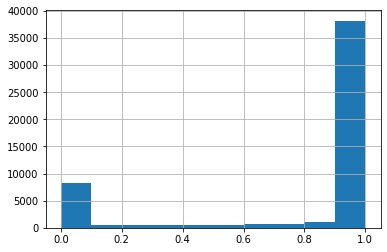

In [23]:
exon_counts2[(exon_counts2.exon_id_38_direct.isna())]['percentage_38'].hist()

<AxesSubplot:>

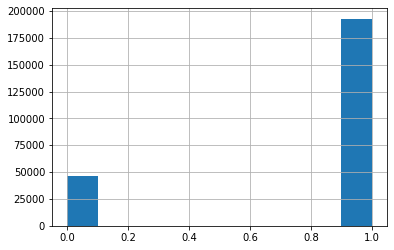

In [21]:
exon_counts2['percentage_37'].hist()

In [61]:
#check if exon_id_38_direct always same as exon_id_38_overlap
#exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 > 0.9)]
exon_counts2[(exon_counts2.apply(lambda x: False if x.exon_id_38_direct==None else (x.exon_id_38_overlap in x.exon_id_38_direct.split(',')), axis=1))]
#187290 
exon_counts2[(~exon_counts2.exon_id_38_overlap.isna())&(~exon_counts2.exon_id_38_direct.isna())&(exon_counts2.apply(lambda x: True if x.exon_id_38_direct==None else (x.exon_id_38_overlap not in x.exon_id_38_direct.split(',')), axis=1))][['exon_id_38_direct','exon_id_38_overlap','percentage_38']]
#187291
#RESULT: always but once ENSE00002483728 	ENSE00002433035 	0.987013
#problem maybe cause of strand? -> ENSE00002483728 better?
#https://www.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000187726;r=11:73964828-73970230;t=ENST00000537753
#https://www.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000255847;r=11:73963657-73970287;t=ENST00000537019

,exon_id_38_direct,exon_id_38_overlap,percentage_38
535777,ENSE00002483728,ENSE00002433035,0.987013


In [56]:
#look into which exons are in GRCh37 but not in GrCh38 
exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 <= 0.9) & (~exon_counts2.exon_id_37_direct.isna())]
exon_counts2[(exon_counts2.percentage_38 > 0.9) & (~exon_counts2.exon_id_37_direct.isna()) & (exon_counts2.apply(lambda x: False if x.exon_id_37_direct==None else (x.exon_id_38_overlap in x.exon_id_37_direct.split(',')), axis=1))][['exon_id_37_direct','exon_id_38_overlap']]
#172913/191171 = 90% , Of all GRCh38 matches 10% of GRCh37 direct matches different
exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 <= 0.9) & (~exon_counts2.exon_id_37_direct.isna()) & (exon_counts2.apply(lambda x: True if x.exon_id_37_direct==None else (x.exon_id_38_overlap not in x.exon_id_37_direct.split(',')), axis=1))][['exon_id_37_direct','exon_id_38_overlap','percentage_38']]
#direct GRCh37 exon predictions of missing exons that are different in GRCh38 
#ENSE00001654260 	ENSE00001558668 	0.102564

,exon_id_37_direct,exon_id_38_overlap,percentage_38
438014,ENSE00002412665,None,0.000000
396800,ENSE00001757284,None,0.000000
905336,ENSE00001654260,ENSE00001558668,0.102564
126767,ENSE00002500251,None,0.000000
756354,ENSE00003092044,None,0.000000
...,...,...,...
359339,ENSE00001289914,ENSE00001899013,0.623555
282242,ENSE00001289329,ENSE00001938989,0.523783
312388,ENSE00001486632,ENSE00003817315,0.865177
929431,"ENSE00001334754,ENSE00001334754",ENSE00001517265,0.462537


In [31]:
exon_counts2[~exon_counts2.exon_id_38_direct.isna() & ~exon_counts2.exon_id_37_direct.isna()][exon_counts2.exon_id_38_direct == exon_counts2.exon_id_37_direct]
# 131.702 / 184.251 direct exon counts same
#TODO doesn't consider in

<ipython-input-31-3d0d53fe72d1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exon_counts2[~exon_counts2.exon_id_38_direct.isna() & ~exon_counts2.exon_id_37_direct.isna()][exon_counts2.exon_id_38_direct == exon_counts2.exon_id_37_direct]


,exon_id_38_direct,start_38,end_38,strand_38,chromosome_38,nr_exonids_38,Start_38_overlap,End_38_overlap,exon_id_38_overlap,Strand_38_overlap,...,nr_exonids_37,Start_37_overlap,End_37_overlap,exon_id_37_overlap,Strand_37_overlap,overlap_37,length_37,percentage_37,chrom_exon_start_37,chrom_exon_end_37
361729,ENSE00001769140,21681679.0,21681684.0,1,7,1,21681679.0,21681684.0,ENSE00001769140,1,...,1,21721297,21721302,ENSE00001769140,1,5,6,0.833333,NaN,NaN
815981,ENSE00001797910,12765829.0,12765834.0,-1,19,1,12765829.0,12765834.0,ENSE00001797910,-1,...,1,12876643,12876648,ENSE00001797910,-1,5,6,0.833333,NaN,NaN
550397,ENSE00002405334,109967314.0,109967319.0,-1,12,1,109967314.0,109967319.0,ENSE00002405334,-1,...,1,110405119,110405124,ENSE00002405334,-1,5,6,0.833333,NaN,NaN
615729,ENSE00001607866,98796206.0,98796213.0,-1,13,1,98796206.0,98796213.0,ENSE00001607866,-1,...,1,99448460,99448467,ENSE00001607866,-1,7,8,0.875000,NaN,NaN
289496,ENSE00001599115,67094157.0,67094165.0,1,5,1,67094157.0,67094165.0,ENSE00001599115,1,...,1,66389985,66389993,ENSE00001599115,1,8,9,0.888889,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342727,ENSE00001055842,102446513.0,102456821.0,1,7,1,102446513.0,102456821.0,ENSE00001055842,1,...,1,102086960,102097268,ENSE00001055842,1,10308,10309,0.999903,NaN,NaN
294001,ENSE00001237325,79728915.0,79739403.0,1,5,1,79728915.0,79739403.0,ENSE00001237325,1,...,1,79024738,79035226,ENSE00001237325,1,10488,10489,0.999905,NaN,NaN
554129,ENSE00001683671,117453012.0,117467205.0,-1,12,1,117453012.0,117467205.0,ENSE00001683671,-1,...,1,117890817,117905010,ENSE00001683671,-1,14193,14194,0.999930,NaN,NaN
868147,ENSE00001422810,8945497.0,8967189.0,-1,19,1,8945497.0,8967189.0,ENSE00001422810,-1,...,1,9056173,9077865,ENSE00001422810,-1,21692,21693,0.999954,NaN,NaN


In [94]:
exon_counts2[(exon_counts2.exon_id_38_direct.isna())]

,exon_id_38_direct,start_38,end_38,strand_38,chromosome_38,nr_exonids_38,Start_38_overlap,End_38_overlap,exon_id_38_overlap,Strand_38_overlap,...,nr_exonids_37,Start_37_overlap,End_37_overlap,exon_id_37_overlap,Strand_37_overlap,overlap_37,length_37,percentage_37,chrom_exon_start_37,chrom_exon_end_37
996745,None,9774045.0,9774319.0,-1,Y,1,9774045.0,9774289.0,ENSE00001782128,-1,...,1,None,None,None,None,0,0,0.000000,9611654.0,9611928.0
956111,None,53038964.0,53040263.0,-1,12,1,53038967.0,53040263.0,ENSE00002414045,-1,...,1,None,None,None,None,0,0,0.000000,53432748.0,53434047.0
956112,None,53039235.0,53039343.0,1,12,1,53039238.0,53039343.0,ENSE00000838126,1,...,1,None,None,None,None,0,0,0.000000,53433019.0,53433127.0
956113,None,53040143.0,53042208.0,1,12,1,53040143.0,53042209.0,ENSE00001309333,1,...,1,None,None,None,None,0,0,0.000000,53433927.0,53435992.0
956114,None,53046853.0,53047057.0,-1,12,1,53046853.0,53047050.0,ENSE00002382397,-1,...,1,None,None,None,None,0,0,0.000000,53440637.0,53440841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32100,None,179099328.0,179109441.0,-1,1,1,179099330.0,179109441.0,ENSE00001445181,-1,...,1,179068463,179078576,ENSE00002219104,-1,10113,10114,0.999901,NaN,NaN
353511,None,139297787.0,139308235.0,1,7,1,139297787.0,139308236.0,ENSE00003705875,1,...,1,138982533,138992981,ENSE00001365241,1,10448,10449,0.999904,NaN,NaN
947156,None,73841382.0,73852753.0,-1,X,1,73841382.0,73852723.0,ENSE00001776501,-1,...,1,73061217,73072588,ENSE00001776501,-1,11371,11372,0.999912,NaN,NaN
15688,None,152302175.0,152314747.0,-1,1,1,152312576.0,152314038.0,ENSE00003888489,1,...,1,152274651,152287223,ENSE00001447981,-1,12572,12573,0.999920,NaN,NaN


In [25]:
#just take good GRCH38 exon id ones for now, 187291 direct matches + drop 4.9%,
counts = pd.concat([exon_counts2[~exon_counts2.exon_id_38_direct.isna()], exon_counts2[(exon_counts2.exon_id_38_direct.isna()) & (exon_counts2.percentage_38 > 0.9)]])[['id','exon_id_38_overlap','exon_id_38_direct']]
counts['exon_id'] = counts.exon_id_38_overlap
counts.loc[~counts.exon_id_38_direct.isna(),'exon_id'] = counts.exon_id_38_direct
counts.drop(['exon_id_38_overlap','exon_id_38_direct'],axis=1,inplace=True)
counts
print(f'Now {len(counts)}/{len(exon_counts2)} = {(len(counts)/len(exon_counts2))*100:.2f}% of exons left, for which we have ids.')
exon_counts = pd.read_feather(f)
exon_counts = counts.merge(exon_counts,how='left',on='id')
exon_counts.to_parquet(path/'KICH'/'exon_counts.parquet')

Now 225461/238796 = 94.42% of exons left, for which we have ids.


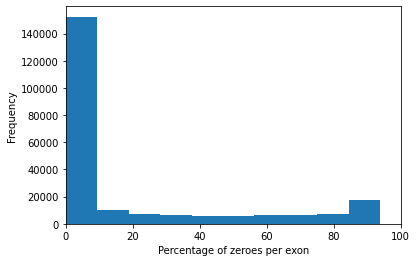

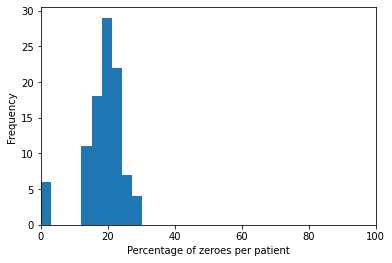

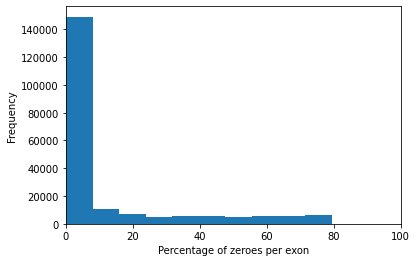

In [4]:
import matplotlib.pyplot as plt 
nan_patientcounts = (exon_counts == 0.0).sum(axis=1)
nan_patientcounts = nan_patientcounts/len(exon_counts.columns)*100
nan_patientcounts.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of zeroes per exon") 
plt.show()
nan_exoncounts = (exon_counts == 0.0).sum()
nan_exoncounts = nan_exoncounts/len(exon_counts)*100
nan_exoncounts.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of zeroes per patient") 
plt.show()
#Filter exons: if not min 80% of patients not zeroes kick out all exon counts for that exon
#10% ignore for model, Rest keep only samples that have expression
a = (exon_counts[(nan_patientcounts<80)] == 0.0).sum(axis=1)
a = a/len(exon_counts.columns)*100
a.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of zeroes per exon") 
plt.show()

In [5]:
exon_counts[(nan_patientcounts<80)]

,id,exon_id,TCGA-KN-8419-01,TCGA-KL-8346-01,TCGA-KN-8422-01,TCGA-KN-8431-11,TCGA-KN-8430-11,TCGA-KM-8440-01,TCGA-KO-8414-01,TCGA-KL-8323-01,...,TCGA-KO-8406-01,TCGA-KO-8408-01,TCGA-KM-8443-01,TCGA-KM-8442-01,TCGA-KL-8332-11,TCGA-KL-8327-01,chromosome_name,chrom_exon_start,chrom_exon_end,strand
0,chr2:231280871-231281043:+,ENSE00002260431,3.1520,1.5735,2.5373,3.4214,2.8588,2.6398,2.2934,2.5007,...,2.6543,1.8614,1.7449,3.4159,2.8171,0.9493,2,230416156,230416328,1
2,chr2:231577557-231577945:+,ENSE00001154635,2.0551,0.3327,1.0442,2.7706,2.0645,1.6066,1.2668,1.4189,...,1.8087,0.5323,1.5580,2.1839,1.8614,0.0257,2,230712842,230713230,1
3,chr12:53290971-53291402:-,ENSE00002364776,7.4997,10.0919,8.7617,7.3892,8.0986,9.1088,8.7055,9.2722,...,8.5726,10.1569,8.3487,9.9985,7.3070,10.8519,12,52897187,52897618,-1
4,chr12:54058945-54059212:-,ENSE00003893235,7.4384,8.6240,7.6027,8.3309,8.0615,8.3384,8.5823,7.8945,...,8.2282,8.8215,8.1973,7.9726,8.8311,7.9968,12,53665161,53665428,-1
5,chr2:228681778-228682280:+,ENSE00001589151,2.2406,0.1232,0.2638,0.2305,0.3121,0.0488,0.0968,0.1518,...,0.0959,0.3484,0.0000,0.3643,1.7205,0.0000,2,227817062,227817564,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225456,chr1:179068463-179078576:-,ENSE00001445181,1.3102,0.6872,0.3714,1.2309,1.3399,0.8103,0.7613,0.9893,...,1.1003,0.7807,0.8816,1.4884,0.6951,0.6588,1,179099328,179109441,-1
225457,chr7:138982533-138992981:+,ENSE00003705875,0.9913,1.2958,0.8459,1.2325,1.2048,1.1043,1.3915,1.4936,...,1.5727,1.2196,1.1603,1.4302,0.5816,1.3016,7,139297787,139308235,1
225458,chrX:73061217-73072588:-,ENSE00001776501,0.0091,0.0000,2.0678,3.0937,0.0022,0.0029,0.2711,3.7480,...,0.9408,0.0037,0.0007,0.0000,0.0096,1.6247,X,73841382,73852753,-1
225459,chr1:152274651-152287223:-,ENSE00003888489,2.0675,0.5735,0.1149,1.1809,1.0308,0.4768,0.8497,0.3446,...,0.1259,0.3589,2.9759,0.5733,0.1897,0.0767,1,152302175,152314747,-1


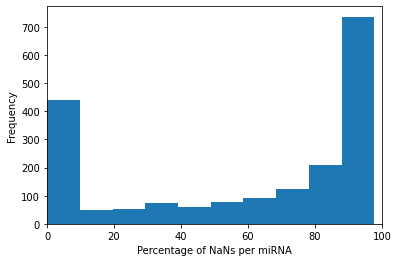

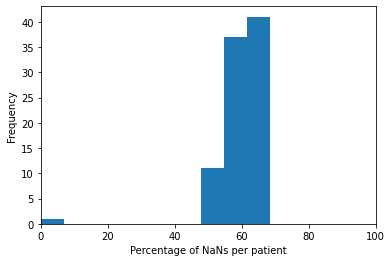

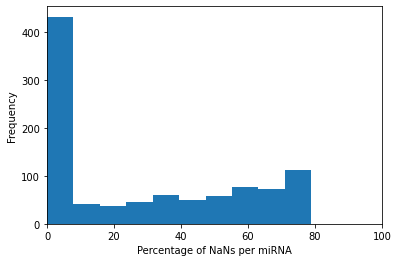

In [9]:
import matplotlib.pyplot as plt 
mirna_counts = pd.read_csv(tcga_path/'miRNA_HiSeq_gene', delimiter='	')
nan_patientcounts = mirna_counts.isnull().sum(axis=1)
nan_patientcounts = nan_patientcounts/len(mirna_counts.columns)*100
nan_patientcounts.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of NaNs per miRNA") 
plt.show()
nan_mirnacounts = mirna_counts.isnull().sum()
nan_mirnacounts = nan_mirnacounts/len(mirna_counts)*100
nan_mirnacounts.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of NaNs per patient") 
plt.show()
#Filter mirnas: if not min 80% of patients not nan kick out all mirna counts for that mirna
#10% ignore for model, Rest keep only samples that have expression
a = mirna_counts[nan_patientcounts<80].isnull().sum(axis=1)
a = a/len(mirna_counts.columns)*100
a.plot(kind='hist')
axes = plt.gca().set_xlim([0,100])
plt.xlabel("Percentage of NaNs per miRNA") 
plt.show()
#mirna_counts

### Outer join exon counts with miRNA counts

In [2]:
exon_counts = pd.read_parquet(path/'KICH'/'exon_counts.parquet')
exon_counts

,id,exon_id,TCGA-KN-8419-01,TCGA-KL-8346-01,TCGA-KN-8422-01,TCGA-KN-8431-11,TCGA-KN-8430-11,TCGA-KM-8440-01,TCGA-KO-8414-01,TCGA-KL-8323-01,...,TCGA-KO-8406-01,TCGA-KO-8408-01,TCGA-KM-8443-01,TCGA-KM-8442-01,TCGA-KL-8332-11,TCGA-KL-8327-01,chromosome_name,chrom_exon_start,chrom_exon_end,strand
0,chr2:231280871-231281043:+,ENSE00002260431,3.1520,1.5735,2.5373,3.4214,2.8588,2.6398,2.2934,2.5007,...,2.6543,1.8614,1.7449,3.4159,2.8171,0.9493,2,230416156,230416328,1
1,chr2:231871937-231871978:+,ENSE00003731983,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,231007222,231007263,1
2,chr2:231577557-231577945:+,ENSE00001154635,2.0551,0.3327,1.0442,2.7706,2.0645,1.6066,1.2668,1.4189,...,1.8087,0.5323,1.5580,2.1839,1.8614,0.0257,2,230712842,230713230,1
3,chr12:53290971-53291402:-,ENSE00002364776,7.4997,10.0919,8.7617,7.3892,8.0986,9.1088,8.7055,9.2722,...,8.5726,10.1569,8.3487,9.9985,7.3070,10.8519,12,52897187,52897618,-1
4,chr12:54058945-54059212:-,ENSE00003893235,7.4384,8.6240,7.6027,8.3309,8.0615,8.3384,8.5823,7.8945,...,8.2282,8.8215,8.1973,7.9726,8.8311,7.9968,12,53665161,53665428,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225456,chr1:179068463-179078576:-,ENSE00001445181,1.3102,0.6872,0.3714,1.2309,1.3399,0.8103,0.7613,0.9893,...,1.1003,0.7807,0.8816,1.4884,0.6951,0.6588,1,179099328,179109441,-1
225457,chr7:138982533-138992981:+,ENSE00003705875,0.9913,1.2958,0.8459,1.2325,1.2048,1.1043,1.3915,1.4936,...,1.5727,1.2196,1.1603,1.4302,0.5816,1.3016,7,139297787,139308235,1
225458,chrX:73061217-73072588:-,ENSE00001776501,0.0091,0.0000,2.0678,3.0937,0.0022,0.0029,0.2711,3.7480,...,0.9408,0.0037,0.0007,0.0000,0.0096,1.6247,X,73841382,73852753,-1
225459,chr1:152274651-152287223:-,ENSE00003888489,2.0675,0.5735,0.1149,1.1809,1.0308,0.4768,0.8497,0.3446,...,0.1259,0.3589,2.9759,0.5733,0.1897,0.0767,1,152302175,152314747,-1


In [3]:
#read in miRNA counts
file = Path(path/'KICH'/'miRNA_counts.parquet')
if file.is_file():
    mirna_counts = pd.read_parquet(file)
else:
    mirna_counts = pd.read_csv(tcga_path/'miRNA_HiSeq_gene', delimiter='	')
    count_nans = mirna_counts.isnull().sum().sum()
    print(f'{count_nans} values are NaN out of {len(mirna_counts)*(len(mirna_counts.columns)-1)} values (={(count_nans/(len(mirna_counts)*(len(mirna_counts.columns)-1)))*100:.2f}%)')
    print(f'amount of NaNs per miRNA: {mirna_counts.isnull().sum(axis=1)}, amount of NaNs per sample: {mirna_counts.isnull().sum()}')
    nan_patientcounts = mirna_counts.isnull().sum(axis=1)/len(mirna_counts.columns)*100
    mirna_counts = mirna_counts[nan_patientcounts<80]
    mirna_counts.to_parquet(file)
mirna_counts

,sample,TCGA-KN-8426-01,TCGA-KN-8419-11,TCGA-KL-8332-01,TCGA-KN-8423-01,TCGA-KO-8405-01,TCGA-KL-8337-01,TCGA-KN-8424-11,TCGA-KN-8422-11,TCGA-KL-8334-01,...,TCGA-KO-8408-01,TCGA-KM-8438-01,TCGA-KL-8323-01,TCGA-KN-8429-11,TCGA-KO-8413-01,TCGA-KO-8411-01,TCGA-KL-8332-11,TCGA-KL-8335-01,TCGA-KL-8339-11,TCGA-KO-8415-01
4,MIMAT0019864,NaN,0.164400,0.177400,NaN,NaN,0.163800,0.424600,NaN,0.20750,...,NaN,0.214300,NaN,NaN,NaN,NaN,NaN,0.180300,NaN,NaN
5,MIMAT0019865,0.308300,NaN,0.177400,NaN,0.249700,0.566606,0.155900,NaN,NaN,...,NaN,NaN,NaN,0.322243,NaN,NaN,NaN,0.180300,0.186200,NaN
7,MIMAT0019867,NaN,NaN,NaN,0.421022,NaN,NaN,NaN,0.431474,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.180300,0.186200,NaN
10,MIMAT0027487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158600,0.20750,...,NaN,0.214300,NaN,NaN,NaN,0.264600,NaN,NaN,NaN,0.218800
11,MIMAT0027486,NaN,NaN,0.177400,0.154400,NaN,NaN,NaN,NaN,0.20750,...,NaN,NaN,0.194100,NaN,NaN,NaN,0.204200,0.180300,0.186200,0.218800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,MIMAT0003293,1.280679,1.060837,0.477751,1.090711,1.433144,0.566606,1.019151,0.431474,1.43373,...,0.963550,0.848472,2.201880,1.000620,0.893648,1.384351,0.542197,1.046136,0.498973,1.980899
1911,MIMAT0027505,NaN,0.445832,0.177400,NaN,NaN,NaN,0.296584,0.301479,0.20750,...,0.346451,NaN,0.656341,NaN,NaN,0.264600,0.204200,0.180300,0.186200,0.408745
1913,MIMAT0019688,NaN,0.164400,0.177400,0.154400,NaN,NaN,NaN,0.158600,0.20750,...,NaN,NaN,NaN,NaN,NaN,NaN,0.204200,0.180300,NaN,NaN
1914,MIMAT0027607,NaN,NaN,NaN,0.293900,NaN,NaN,0.155900,0.158600,NaN,...,0.346451,NaN,NaN,NaN,NaN,0.264600,0.204200,NaN,0.186200,0.218800


### Elastic Net Regression

In [39]:
#TODO change:for now exon_id can also be several!!!
a[a.exon_id == 'ENSE00003898929,ENSE00003636032,ENSE00003898111']

,id,exon_id,chromosome_name,chrom_exon_start,chrom_exon_end,strand,case_id,exon_count
157959,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KN-8419-01,1.7035
383420,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KL-8346-01,0.8893
608881,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KN-8422-01,0.6560
834342,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KN-8431-11,1.5468
1059803,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KN-8430-11,0.8479
...,...,...,...,...,...,...,...,...
19547605,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KO-8408-01,0.9510
19773066,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KM-8443-01,1.6258
19998527,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KM-8442-01,2.5080
20223988,chr8:67705851-67706067:+,"ENSE00003898929,ENSE00003636032,ENSE00003898111",8,66793616,66793832,1,TCGA-KL-8332-11,2.4118


In [41]:
#melt caseids to rows & pivot exon ids to column header
exon_counts = exon_counts.melt(id_vars=['id','exon_id','chromosome_name','chrom_exon_start','chrom_exon_end','strand'], var_name="case_id", value_name="exon_count")
exon_counts = exon_counts[['exon_id','case_id','exon_count']].pivot_table(index=['case_id'], columns='exon_id', values = 'exon_count')
exon_counts

exon_id,ENSE00000000003,ENSE00000000004,ENSE00000000010,"ENSE00000000011,ENSE00002052017",ENSE00000000015,ENSE00000000017,ENSE00000000026,"ENSE00000000027,ENSE00001580878",ENSE00000000035,ENSE00000000048,...,"ENSE00003898885,ENSE00001046995,ENSE00003898826","ENSE00003898891,ENSE00003898406,ENSE00003692170","ENSE00003898892,ENSE00003898462","ENSE00003898898,ENSE00003561755,ENSE00003472778","ENSE00003898925,ENSE00001475019","ENSE00003898929,ENSE00003636032,ENSE00003898111",ENSE00003898941,"ENSE00003898955,ENSE00000893255","ENSE00003898963,ENSE00003559787,ENSE00003478358",ENSE00003898976
case_id,,,,,,,,,,,,,,,,,,,,,
TCGA-KL-8323-01,3.0760,4.8985,1.0327,1.6285,8.6586,0.0185,2.9807,0.0387,2.9271,0.9152,...,5.0361,3.6584,3.5670,0.0000,2.1104,2.5988,0.0520,2.3276,0.0000,4.9491
TCGA-KL-8324-01,2.7936,4.5504,0.8596,0.1141,9.0504,0.0000,1.8543,0.0839,4.1004,1.1920,...,2.8984,2.2640,2.4340,0.1381,3.0804,1.3988,0.0572,0.5099,0.0000,5.0750
TCGA-KL-8324-11,4.2079,4.9434,2.0884,0.7591,7.7742,0.0000,4.1215,0.2583,5.4443,3.9318,...,5.3613,3.5972,3.6158,0.0000,1.6621,2.0730,0.1549,2.4340,0.0000,6.0310
TCGA-KL-8325-01,3.3865,5.2853,0.5602,2.6351,8.4757,0.0089,3.3058,0.6761,3.4671,0.7092,...,6.1575,4.6462,4.7193,0.0000,2.5519,3.2958,0.0978,3.0416,0.0000,5.2276
TCGA-KL-8326-01,2.9576,5.0798,1.2163,0.0000,7.3191,0.0000,1.8939,0.0996,2.5959,0.8076,...,1.9644,1.9411,1.8659,0.0000,0.9759,0.5367,0.0000,0.9536,0.0000,5.6072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-KO-8414-01,3.1081,5.3191,1.2618,0.0000,9.4519,0.0000,1.7184,0.0000,2.7697,1.3199,...,3.4390,1.5772,1.5806,0.0000,1.5476,0.6445,0.0000,1.1918,0.0000,5.1409
TCGA-KO-8415-01,2.3007,4.3822,1.0820,0.1152,9.6197,0.0000,1.8505,0.0430,3.8697,0.8389,...,2.7685,1.6036,1.7873,0.0000,0.7528,0.7380,0.0000,1.3886,0.0000,5.2321
TCGA-KO-8415-11,3.9467,5.2515,2.2069,1.0754,8.2121,0.0609,3.8523,0.0570,5.4253,2.6085,...,5.6896,3.5032,3.5855,0.0000,1.6128,2.0177,0.2180,2.3381,0.0000,6.0245


In [63]:
#regression btw miRNA expression, exon expression
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
#faster if np.array(x, order='F')
#If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:
#a * L1 + b * L2 where: alpha = a + b and l1_ratio = a / (a + b)

coefficients = {}
for mirna in mirna_counts['sample']:
    y_info = mirna_counts[mirna_counts['sample'] == mirna].melt(id_vars=['sample'], var_name="case_id", value_name="mirna_count").dropna()
    X_info = y_info.merge(exon_counts,on='case_id',how='left').drop('mirna_count',axis=1)
    y = y_info.mirna_count
    X = X_info.drop(['sample','case_id'],axis=1)
    regr = ElasticNet(random_state=0)
    regr.fit(X, y)
    coefficients[mirna] = regr.coef_
    #print(regr.intercept_)
#for all mirnas 23.40-0.50 390GB?
import pickle
with open((path/'KICH'/'coefficients.pickle'),"wb") as file:
    pickle.dump(coefficients,file, protocol=pickle.HIGHEST_PROTOCOL)

/nfs/home/users/l.hackl/.conda/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34043233784898064, tolerance: 0.14937680937261286
  model = cd_fast.enet_coordinate_descent(


In [2]:
import pickle
with open((path/'KICH'/'coefficients.pickle'), 'rb') as handle:
    coefficients = pickle.load(handle)
#coefficients

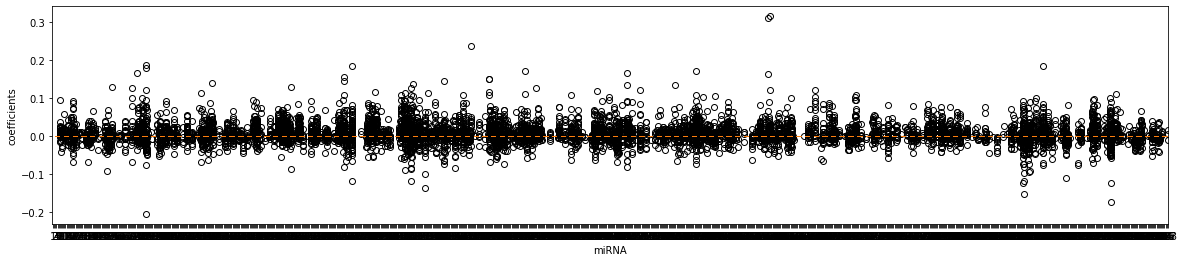

In [105]:
#plot 
fig1, ax1 = plt.subplots(figsize=(20,4))
plt.xlabel('miRNA')
plt.ylabel('coefficients')
ax1.boxplot(list(coefficients.values()))
#ax1.set_xticklabels(list(coefficients.keys()), rotation=90, ha='right')
plt.show()

In [6]:
all_coefficients = [item for sublist in coefficients.values() for item in sublist]

In [ ]:
import matplotlib.pyplot as plt 
fig1, ax1 = plt.subplots(figsize=(5,10))
plt.ylabel('coefficients')
ax1.boxplot(all_coefficients)
ax1.set_xticklabels(['Kidney Chromophobe'])
plt.show()#67gb